In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import os
import sys
from pathlib import Path

import torch
import torch.utils.data
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt

import pvi
from pvi.models import ClassificationBNNLocalRepam, ClassificationBNN
from pvi.clients import Client
from pvi.servers import SequentialServer
from pvi.distributions import MeanFieldGaussianDistribution, MeanFieldGaussianFactor
from pvi.utils.training_utils import EarlyStopping
from tqdm.auto import tqdm
import logging

In [3]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

In [4]:
data_dir = Path("../../data/")
cache_dir = Path("../../cache")

In [5]:
import bayesfunc
from bayesfunc import GILinear

## Define various functions for splitting data and recording performance metrics.

In [6]:
# Data splitting functions.
def homogeneous_split(data, num_clients=100, seed=42):
    # Set numpy's random seed.
    np.random.seed(seed)
    
    perm = np.random.permutation(len(data["x"]))
    client_data = []
    for i in range(num_clients):
        client_idx = perm[i::num_clients]
        client_data.append({"x": data["x"][client_idx], "y": data["y"][client_idx]})
    
    return client_data


# Performance metric function.
def performance_metrics(client, data, batch_size=512):
    dataset = torch.utils.data.TensorDataset(data["x"], data["y"])
    loader = torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=False)
    
    device = client.config["device"]
    
    if device == "cuda":
        loader.pin_memory = True
        
    preds, mlls = [], []
    for (x_batch, y_batch) in loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        pp = client.model_predict(x_batch)
        preds.append(pp.component_distribution.probs.mean(1).cpu())
        mlls.append(pp.log_prob(y_batch).cpu())
        
    mll = torch.cat(mlls).mean()
    preds = torch.cat(preds)
    acc = sum(torch.argmax(preds, dim=-1) == loader.dataset.tensors[1]) / len(
        loader.dataset.tensors[1]
    )
    
    return {"mll": mll, "acc": acc}

## Data preprocessing

In [7]:
transform_train = transforms.Compose([transforms.ToTensor()])
transform_test = transforms.Compose([transforms.ToTensor()])

train_set = datasets.MNIST(root=data_dir, train=True, download=True, transform=transform_train)
test_set = datasets.MNIST(root=data_dir, train=False, download=True, transform=transform_test)

train_data = {
    "x": ((train_set.data - 0) / 255).reshape(-1, 28 * 28),
    "y": train_set.targets,
}

test_data = {
    "x": ((test_set.data - 0) / 255).reshape(-1, 28 * 28),
    "y": test_set.targets,
}

In [8]:
# Get client splits.
client_data = homogeneous_split(train_data, 10, seed=42)

## Define configuration for server and clients

In [9]:
model_config = {
    "input_dim": 784,
    "latent_dim": 200,
    "output_dim": 10,
    "num_layers": 1,
    "num_predictive_samples": 100,
    "prior_var": 1.0,
}

client_config = {
    "damping_factor": 1.0, # damping of approx lls to get a proper q distrib
    "optimiser": "Adam",
    "optimiser_params": {"lr": 2e-3},
    "sigma_optimiser_params": {"lr": 2e-3},
    "early_stopping": EarlyStopping(5, score_name="elbo", stash_model=True),
    "performance_metrics": performance_metrics,
    "batch_size": 512,
    "epochs": 1000,
    "print_epochs": np.inf,
    "num_elbo_samples": 10,
    "valid_factors": False,
    "device": "cuda",
    "init_var": 1e-3,
    "verbose": True,
}

server_config = {
    **client_config,
    "max_iterations": 10
}

## Set up model etc.

In [17]:
client_data[0]['x'].shape

torch.Size([6000, 784])

In [20]:
input_sample = client_data[0]['x'][0]

In [26]:
model.forward(input_sample.to(device), init_q)

MixtureSameFamily(
  Categorical(logits: torch.Size([1, 100])),
  Categorical(logits: torch.Size([1, 100, 10])))

In [13]:
device = server_config["device"]

model = ClassificationBNNLocalRepam(config=model_config)
# model = ClassificationBNN(config=model_config)

# Initial parameters.
init_q_std_params = {
    "loc": torch.zeros(size=(model.num_parameters,)).to(device).uniform_(-0.1, 0.1),
    "scale": torch.ones(size=(model.num_parameters,)).to(device) 
    * client_config["init_var"] ** 0.5,
}

prior_std_params = {
    "loc": torch.zeros(size=(model.num_parameters,)).to(device),
    "scale": model_config["prior_var"] ** 0.5 
    * torch.ones(size=(model.num_parameters,)).to(device),
}

init_factor_nat_params = {
    "np1": torch.zeros(model.num_parameters).to(device),
    "np2": torch.zeros(model.num_parameters).to(device),
}

p = MeanFieldGaussianDistribution(
    std_params=prior_std_params, is_trainable=False
)
init_q = MeanFieldGaussianDistribution(
    std_params=init_q_std_params, is_trainable=False
)

clients = []
for i in range(10):
    data_i = client_data[i]
    t_i = MeanFieldGaussianFactor(nat_params=init_factor_nat_params)
    clients.append(
        Client(
            data=data_i,
            model=model,
            t=t_i,
            config=client_config,
            val_data=test_data
        )
    )
    
server = SequentialServer(model=model, p=p, clients=clients, config=server_config, init_q=init_q, data=train_data, val_data=test_data)

## Run PVI!

In [33]:
compiled_log = server.get_compiled_log()

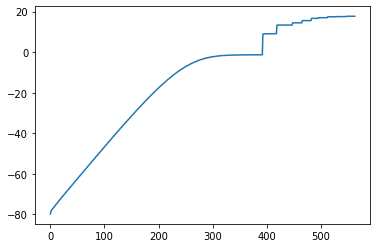

In [41]:
# Training ELBO across iterations of Client 0
training_elbo = []
for dd in compiled_log['client_0']['training_curves']:
    training_elbo.extend(dd['elbo'])

plt.plot(training_elbo)

In [14]:
i = 0

# with tqdm(total=server_config['max_iterations'], position=0, leave=True) as pbar:
while not server.should_stop():
  server.tick()
  
  # Obtain performance metrics.
  metrics = server.log["performance_metrics"][-1]
  # print("Iterations: {}.".format(i))
  # print("Time taken: {:.3f}.".format(metrics["time"]))

  report = "Test mll: {:.3f}. Test acc: {:.3f}. Train mll: {:.3f}. Train acc: {:.3f} ".format(metrics["val_mll"], metrics["val_acc"], metrics["train_mll"], metrics["train_acc"])
  print('\r'+report, flush=True)
  # print(
  #   "Test mll: {:.3f}. Test acc: {:.3f}.".format(
  #       metrics["val_mll"], metrics["val_acc"]
  #   )
  # )
  # print(
  #   "Train mll: {:.3f}. Train acc: {:.3f}.\n".format(
  #       metrics["train_mll"], metrics["train_acc"]
  #   )
  # )
  # pbar.update(1)
  i += 1

Epoch:   3%|▎         | 30/1000 [00:02<01:28, 10.92it/s, elbo=9.87, kl=-9.99, ll=-.126, logt=0, lr=0.002]


Test mll: -0.098. Test acc: 0.970. Train mll: -0.089. Train acc: 0.975 


Epoch:   2%|▏         | 15/1000 [00:01<01:34, 10.46it/s, elbo=13.7, kl=-13.8, ll=-.125, logt=0, lr=0.002]


Test mll: -0.090. Test acc: 0.974. Train mll: -0.080. Train acc: 0.979 


Epoch:   2%|▏         | 15/1000 [00:01<01:33, 10.58it/s, elbo=14.5, kl=-14.6, ll=-.119, logt=0, lr=0.002]


Test mll: -0.088. Test acc: 0.975. Train mll: -0.077. Train acc: 0.981 


Epoch:   1%|          | 12/1000 [00:01<01:36, 10.22it/s, elbo=15.6, kl=-15.7, ll=-.117, logt=0, lr=0.002]


Test mll: -0.087. Test acc: 0.975. Train mll: -0.075. Train acc: 0.981 


Epoch:   1%|          | 12/1000 [00:01<01:34, 10.50it/s, elbo=16.6, kl=-16.7, ll=-.116, logt=0, lr=0.002]


Test mll: -0.085. Test acc: 0.976. Train mll: -0.073. Train acc: 0.982 


Epoch:   2%|▏         | 24/1000 [00:02<01:29, 10.85it/s, elbo=16.9, kl=-17, ll=-.116, logt=0, lr=0.002]


Test mll: -0.084. Test acc: 0.975. Train mll: -0.072. Train acc: 0.982 


Epoch:   1%|          | 8/1000 [00:00<01:36, 10.27it/s, elbo=17.4, kl=-17.6, ll=-.117, logt=0, lr=0.002]


Test mll: -0.085. Test acc: 0.976. Train mll: -0.071. Train acc: 0.983 


Epoch:   1%|          | 7/1000 [00:00<01:34, 10.49it/s, elbo=17.5, kl=-17.6, ll=-.115, logt=0, lr=0.002]


Test mll: -0.084. Test acc: 0.976. Train mll: -0.070. Train acc: 0.983 


Epoch:   1%|          | 11/1000 [00:00<01:29, 11.07it/s, elbo=17.6, kl=-17.8, ll=-.114, logt=0, lr=0.002]


Test mll: -0.083. Test acc: 0.976. Train mll: -0.069. Train acc: 0.983 


Epoch:   1%|▏         | 14/1000 [00:01<01:36, 10.24it/s, elbo=18.2, kl=-18.3, ll=-.112, logt=0, lr=0.002]


Test mll: -0.084. Test acc: 0.976. Train mll: -0.069. Train acc: 0.984 


In [ ]:
Same speed for both